<a href="https://colab.research.google.com/github/Yahred/evolutionary-computation/blob/main/CGAOptimizationProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolución de un problema de optimización a través de un algoritmo genético

**Enunciado del problema**

La	siguiente	gráfica	corresponde	al	distribución	de	una	carpintería	local	que	se
encarga	el	proceso	de	elaboración	de	una	silla.

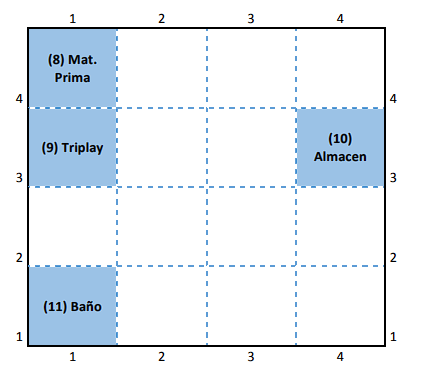

El	problema	es	que	la	carpintería	no	sabe	donde	ubicar	las	distintas	maquinas	de
trabajo	en	el	espacio	descrito.	La	maquinaria	para	realizar	el	proceso	de
elaboración	de	la	silla	es	el	siguiente

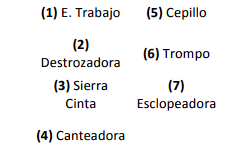

Cada	maquinaria	puede	ser	ubicada	en	los	espacios	de	2	x	2	y	en	los	espacios	en
blanco	descritos	en	la	grafica	anterior.		Los	espacios	descritos	en	color	azul	son
espacios	fijos	y	no	pueden	moverse	de	su	lugar

Y	el	recorrido	para	realizar	la	tarea	es	el	siguiente:

* 1 al 8
* 8 al 1
* 1 al 4
* 4 al 5
* 5 al 3
* 3 al 4
* 4 al 3
* 3 al 1
* 1 al 9
* 9 al 1
* 1 al 3
* 3 al 1
* 1 al 10

Encuentra	la	configuración	de	la	carpintería	que	minimice	el	recorrido	del
personal

# Setup del notebook

Bloque de código para importar los módulos necesarios

In [2]:
 pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.5 MB/s eta 0:00:00


In [3]:
from deap import base, creator, tools, algorithms

import numpy as np
import matplotlib.pyplot as plt

import math
import random

# Configuración de la evolución

A continuación se define la función de aptitud



In [18]:
class Estacion:
  def __init__(self, id: int, nombre: str, x: int, y: int) -> None:
    self.id = id
    self.nombre = nombre
    self.x = x
    self.y = y

  def __str__(self) -> str:
    return '{} x: {}, y: {}'.format(self.nombre, self.x, self.y)

estaciones_nombres = {
   1: 'E. Trabajo',
   2: 'Destrozadora',
   3: 'Sierra cinta',
   4: 'Canteadora',
   5: 'Cepillo',
   6: 'Trompo',
   7: 'Esclopeadora',
}

estaciones_iniciales = {
    8: Estacion(8, 'Mat.Prima', 1, 4),
    9: Estacion(9, 'Triplay', 1, 3),
    10: Estacion(10, 'Almacen', 4, 3),
    11: Estacion(11, 'Baño', 1, 1),
}

posiciones_ocupadas = {
    '1,1': True,
    '1,3': True,
    '1,4': True,
    '4,3': True,
}

fenotipo = {
    0: (1, 2),
    1: (2, 1),
    2: (2, 2),
    3: (2, 3),
    4: (2, 4),
    5: (3, 1),
    6: (3, 2),
    7: (3, 3),
    8: (3, 4),
    9: (4, 1),
    10: (4, 2),
    11: (4, 2),
}

genes = 7

ruta = [1, 8, 1, 4, 5, 3, 4, 3, 1, 9, 1, 3, 1, 10]

In [5]:
def calcular_distancia(a: Estacion, b: Estacion) -> int:
  return math.sqrt(math.pow(b.x - a.x, 2) + math.pow(b.y - a.y, 2))

In [22]:
def ind_to_estaciones(ind: list[int]) -> list[Estacion]:
  posiciones = [fenotipo[gen] for gen in ind]
  estaciones = estaciones_iniciales.copy()
  for i in range(len(posiciones)):
    x, y = posiciones[i]
    estacion = Estacion(i + 1, estaciones_nombres[i + 1], x, y)
    estaciones[i + 1] = estacion

  return estaciones


def fitness(ind: list[int]):
  estaciones = ind_to_estaciones(ind)
  acc = 0
  for i in range(1, len(ruta)):
    a = ruta[i - 1]
    b = ruta[i]
    estacion_a = estaciones[a]
    estacion_b = estaciones[b]
    acc += calcular_distancia(estacion_a, estacion_b)

  return acc,


# Configuración de los individuos

El individuo estará compuesto por números entre el 0 y el 11 (inclusivo) en el que cada gen representa una de las 11 posibles posiciones que puede tomar la estación en la posición i del cromosoma

In [93]:
def crear_individuo():
  ind = list(range(len(fenotipo)))
  random.shuffle(ind)
  return ind[0: genes]

Se define una operación de cruza personalizada que asegure que no hay repeticiones en los genes del cromosoma del individup

In [105]:
def cruza(a, b):
    base = []
    for (a_gen, b_gen) in zip(a, b):
      if a_gen == b_gen:
        base.append(a_gen)
        continue

      base.append(None)

    offspring = [toolbox.clone(ind) for ind in (a, b)]
    for child in offspring:
      for (index, gen) in enumerate(base):
        if gen:
          child[index] = gen
          continue

        selection = None
        while selection is None or selection in child:
          selection = random.randint(0, len(fenotipo) - 1)

        child[index] = selection
        del child.fitness.values

    return offspring

In [113]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", cruza)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)

In [114]:
ind = toolbox.individual()
ind

[3, 4, 5, 9, 0, 1, 11]

# Evolución

In [122]:
random.seed(64)
n_gen = 50
initial_pop = 100

pop = toolbox.population(n=initial_pop)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0, ngen=n_gen, halloffame=hof, verbose=True, stats=stats)

ganador = tools.selBest(pop, k=1)[0]

gen	nevals	avg    
0  	100   	26.8809
1  	44    	23.5931
2  	58    	22.1903
3  	42    	20.3875
4  	48    	19.4321
5  	50    	18.6651
6  	48    	16.6012
7  	60    	16.4232
8  	56    	16.2014
9  	54    	16.139 
10 	56    	16.3717
11 	46    	15.8924
12 	46    	15.9594
13 	44    	15.9119
14 	54    	15.9399
15 	58    	15.9464
16 	42    	15.8189
17 	52    	15.8247
18 	38    	15.8208
19 	62    	15.8878
20 	36    	15.8085
21 	50    	15.7421
22 	54    	15.7961
23 	64    	15.8319
24 	46    	15.8202
25 	54    	15.8143
26 	50    	15.7232
27 	50    	15.6926
28 	38    	15.7473
29 	52    	15.6751
30 	60    	15.7597
31 	54    	15.7232
32 	66    	15.6991
33 	50    	15.6569
34 	46    	15.6569
35 	48    	15.6569
36 	42    	15.6569
37 	52    	15.6569
38 	54    	15.6569
39 	60    	15.6569
40 	52    	15.6569
41 	64    	15.6569
42 	50    	15.6569
43 	54    	15.6569
44 	48    	15.6569
45 	42    	15.6569
46 	50    	15.6569
47 	52    	15.6569
48 	66    	15.6569
49 	46    	15.6569
50 	42    	15.6569


In [123]:
ganador

[3, 10, 2, 6, 7, 9, 1]

# Resultados

A continuación se desplega una gráfica del acomodo optimo según el individuo ganador

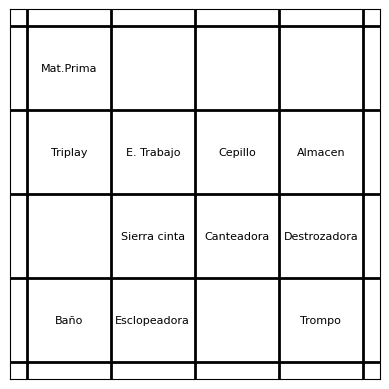

In [124]:
fig, ax = plt.subplots()
for i in range(5):
    ax.axhline(y=i, color='k', linewidth=2)
    ax.axvline(x=i, color='k', linewidth=2)

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

estaciones = ind_to_estaciones(ganador)
padding = 0.5
for estacion in estaciones.values():
  ax.text(estacion.x - 1 + padding, estacion.y - 1 + padding, estacion.nombre, ha='center', va='center', fontsize=8)

plt.show()